# Process the Mortgage Acquisition files

    Include Mortgages where:
    
    Property Type       = Single Family
    Number of Units     = 1
    Occupancy Type      = Principal
    Loan Purpose        = Purchase, Cash-Out Refi, No Cash-Out Refi, Refinance-Not Specified
    Original Loan (Term)= 60-419 months

## Import Dependencies

In [1]:
import csv
from pathlib import Path
import pandas as pd
import glob
from datetime import datetime, timedelta
import seaborn as sns
from settings_prep import *

In [2]:
outputFileName = 'FMAcqProcessedPurchRefi.csv'

# Get the Single-Family Loan Acquisition Data Files from Fannie Mae

From the Fannie Mae [website:](https://loanperformancedata.fanniemae.com/lppub/index.html#Single-Family_Loan_Performance_Data_Files) we downloaded the Acquisition dataset (998MB zip file)

The [Acquisition file layout](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf) was as follows:
![Acquisition File Layout](../images/AcquisitionFileLayoutMedium.jpg)

In [3]:
# Create mapping for the header of the files based on above file format
headerline = ['loanIdentifier','origChannel','sellerName','origIntRate','origUPB','origLoanTerm',\
         'origDate','firstPmtDate','origLTV','origCLTV','numBorrowers','origDebtIncRatio',\
         'borrCreditScore','firstTHBI','loanPurp','propType','numUnits','occType','propState',\
         'zipCode','pMIperct','prodType','coborrCreditScore','mortInsType','relocMortInd']

In [4]:
# Loop through each file from the unzipped download file - which gave a set of 76 individual files

#Create an empty array to hold dataframes to later concatonate
li = []

#Loop through every file in the directory and append into array
for in_path in Path('D:\Acquisition_All').glob('Acquisition*.txt'):
    df = pd.read_csv(in_path, sep="|", index_col=None, header=None)
    li.append(df)

#Concatonate all the array elements into one giant dataframe
df = pd.concat(li, axis=0, ignore_index=True)
df.columns = headerline

In [5]:
df.shape

(41294721, 25)

In [6]:
#Review the columns for datatypes and how many non-null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41294721 entries, 0 to 41294720
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   loanIdentifier     int64  
 1   origChannel        object 
 2   sellerName         object 
 3   origIntRate        float64
 4   origUPB            int64  
 5   origLoanTerm       int64  
 6   origDate           object 
 7   firstPmtDate       object 
 8   origLTV            float64
 9   origCLTV           float64
 10  numBorrowers       float64
 11  origDebtIncRatio   float64
 12  borrCreditScore    float64
 13  firstTHBI          object 
 14  loanPurp           object 
 15  propType           object 
 16  numUnits           int64  
 17  occType            object 
 18  propState          object 
 19  zipCode            int64  
 20  pMIperct           float64
 21  prodType           object 
 22  coborrCreditScore  float64
 23  mortInsType        float64
 24  relocMortInd       object 
dtypes: float64(9), i

In [7]:
df.head()

,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origLoanTerm,origDate,firstPmtDate,origLTV,origCLTV,...,propType,numUnits,occType,propState,zipCode,pMIperct,prodType,coborrCreditScore,mortInsType,relocMortInd
0,100007365142,R,"JPMORGAN CHASE BANK, NA",8.000,75000,360,12/1999,02/2000,79.0,NaN,...,SF,1,P,PA,173,NaN,FRM,NaN,NaN,N
1,100007386460,B,"JPMORGAN CHASE BANK, NA",7.875,55000,180,01/2000,03/2000,69.0,NaN,...,CO,1,P,MD,208,NaN,FRM,NaN,NaN,N
2,100011322040,C,AMTRUST BANK,7.750,123000,360,11/1999,01/2000,80.0,NaN,...,SF,1,P,MO,630,NaN,FRM,NaN,NaN,N
3,100015192562,R,OTHER,8.500,51000,360,02/2000,04/2000,95.0,NaN,...,SF,1,P,GA,316,25.0,FRM,NaN,1.0,N
4,100015874399,C,"CITIMORTGAGE, INC.",8.750,242000,360,02/2000,04/2000,95.0,NaN,...,SF,1,P,FL,335,30.0,FRM,NaN,1.0,N


### Let's take a look at how many null values there are in each column

In [8]:
df.apply(lambda x: x.isnull().sum(), axis=0)

loanIdentifier              0
origChannel                 0
sellerName                  0
origIntRate                 6
origUPB                     0
origLoanTerm                0
origDate                    0
firstPmtDate                0
origLTV                    11
origCLTV               307137
numBorrowers             9850
origDebtIncRatio       765890
borrCreditScore        160888
firstTHBI                   0
loanPurp                    0
propType                    0
numUnits                    0
occType                     0
propState                   0
zipCode                     0
pMIperct             33624509
prodType                    0
coborrCreditScore    20781879
mortInsType          33624509
relocMortInd                0
dtype: int64

### Convert the origDate,firstPmtDate columns from strings to datetime datatypes
Since this will be such a large dataset I tested a number of methods to change datatypes

`%timeit df['origDate'] = pd.to_datetime(df['origDate'], format='%m/%Y')`  
5.43 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

`%timeit df['origDate'].apply(lambda _: datetime.strptime(_,"%m/%Y"))')`  
5.48 ms ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Not much difference in speeds so I'll choose the `to_datetime` method

In [9]:
df['origDate'] = pd.to_datetime(df['origDate'], format='%m/%Y')
df['firstPmtDate'] = pd.to_datetime(df['firstPmtDate'], format='%m/%Y')

### Filter out records with values we aren't interested in examining:

Using the [Glossary](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf) of column names we made the following selections:
![Property Type](images/propertyType.jpg)
* Property type: only want 'SF' - 'Single Family'

<AxesSubplot:xlabel='propType', ylabel='count'>

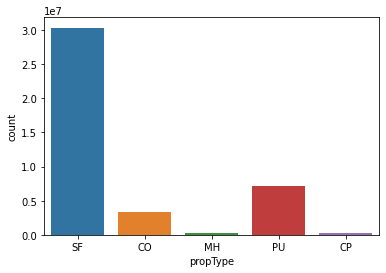

In [10]:
sns.countplot(df['propType'])

### Most property type loans were made for Single Family loans - so we can eliminate the others

In [11]:
propTypeFilter = ['SF']
df = df[df.propType.isin(propTypeFilter)]
df.shape

(30336301, 25)

![Number of Units](images/numUnits.jpg)
* Number of Units: only want '1'

<AxesSubplot:xlabel='numUnits', ylabel='count'>

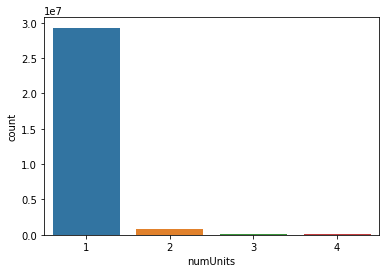

In [12]:
sns.countplot(df['numUnits'])

### Most Number of Units were "1" - so we can eliminate the others

In [13]:
numUnitsFilter = [1]
df = df[df.numUnits.isin(numUnitsFilter)]
df.shape

(29308889, 25)

![Occupany Type](images/occType.jpg)
* Occupancy Type: only want 'Principal'

<AxesSubplot:xlabel='occType', ylabel='count'>

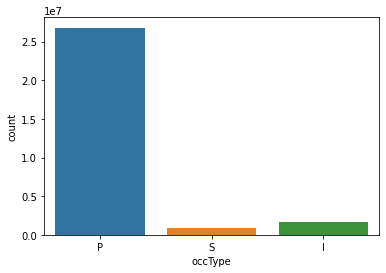

In [14]:
sns.countplot(df['occType'])

### Most Occupancy Type loans were for "Principal" - so we can eliminate the others

In [15]:
occTypeFilter = ['P']
df = df[df.occType.isin(occTypeFilter)]
df.shape

(26796326, 25)

![Loan Purpose](images/loanPurp.jpg)
* Loan Purpose: we want 'All'

<AxesSubplot:xlabel='loanPurp', ylabel='count'>

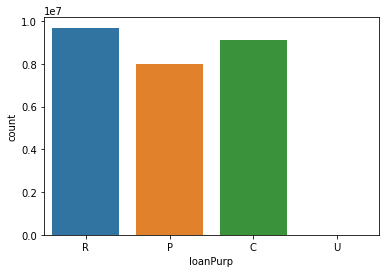

In [16]:
sns.countplot(df['loanPurp'])

### Loan Purpose was almost evenly distributed amongst P, C, R - so we won't eliminate anything here

In [17]:
# loanPurpFilter = ['C','R','U']
# df = df[df.loanPurp.isin(loanPurpFilter)]
df.shape

(26796326, 25)

![Number of Units](images/origLoanTerm.jpg)
* Number of Units: only want '360'

<AxesSubplot:xlabel='origLoanTerm', ylabel='count'>

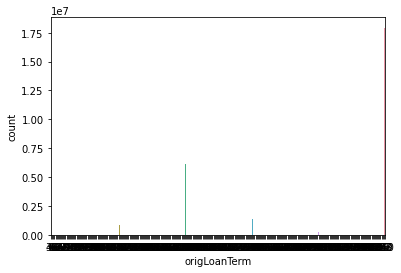

In [18]:
sns.countplot(df['origLoanTerm'])

### Loan Term had several "spikes" of different loan terms with 360 being the most prevalent - decided we won't eliminate anything here

In [19]:
# origLoanTermFilter = [360]
# df = df[df.origLoanTerm.isin(origLoanTermFilter)]
df.shape

(26796326, 25)

### Let's see how these filters affected the count of null values in each column

In [20]:
df.apply(lambda x: x.isnull().sum(), axis=0)

loanIdentifier              0
origChannel                 0
sellerName                  0
origIntRate                 3
origUPB                     0
origLoanTerm                0
origDate                    0
firstPmtDate                0
origLTV                     6
origCLTV               235736
numBorrowers             7472
origDebtIncRatio       517299
borrCreditScore        111064
firstTHBI                   0
loanPurp                    0
propType                    0
numUnits                    0
occType                     0
propState                   0
zipCode                     0
pMIperct             21802254
prodType                    0
coborrCreditScore    13056416
mortInsType          21802254
relocMortInd                0
dtype: int64

### Fill null values with 0 for the following columns
We can't have NaN or Null values for the machine learning part to come

In [21]:
df['mortInsType'] = df['mortInsType'].fillna(0)
df['pMIperct'] = df['pMIperct'].fillna(0)
# df['origCLTV'] = df['origCLTV'].fillna(0)

## Calculate the 'Best', 'Worst' and 'Avg' Credit Score
Given that there is a Borrower Credit Score and a Co-Borrower Credit Score and that there are Null values for each we want to create calculated columns where no Null values exist and then drop the original columns

In [22]:
df['bestCreditScore'] = df[['borrCreditScore','coborrCreditScore']].max(axis=1)
df['worstCreditScore'] = df[['borrCreditScore','coborrCreditScore']].min(axis=1)
df['avgCreditScore'] = df[['borrCreditScore','coborrCreditScore']].mean(axis=1)

### Get rid of records where there are NaN or NULL values for:
* 'origIntRate'
* 'origLTV'
* 'origCLTV'
* 'numBorrowers'
* 'origDebtIncRatio'
* 'bestCreditScore'
* 'worstCreditScore'
* 'avgCreditScore'
* 'numBorrowers'

In [23]:
df = df[df['origIntRate'].notna() &\
        df['origLTV'].notna() &\
        df['origCLTV'].notna() &\
        df['numBorrowers'].notna() &\
        df['origDebtIncRatio'].notna() &\
        df['bestCreditScore'].notna() &\
        df['worstCreditScore'].notna() &\
        df['avgCreditScore'].notna() &\
        df['numBorrowers'].notna()]

### Drop all columns where there is only a single value and also coborrower Credit Score and original credit score  (since we now have the calculated values of 'best', 'worst' and 'avg'
* 'borrCreditScore'
* 'coborrCreditScore'

In [24]:
df = df.drop(['prodType','firstTHBI','relocMortInd','occType','numUnits','coborrCreditScore', 'borrCreditScore','propType'], axis=1)

In [25]:
df.apply(lambda x: x.isnull().sum(), axis=0)

loanIdentifier      0
origChannel         0
sellerName          0
origIntRate         0
origUPB             0
origLoanTerm        0
origDate            0
firstPmtDate        0
origLTV             0
origCLTV            0
numBorrowers        0
origDebtIncRatio    0
loanPurp            0
propState           0
zipCode             0
pMIperct            0
mortInsType         0
bestCreditScore     0
worstCreditScore    0
avgCreditScore      0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25993874 entries, 711 to 41294720
Data columns (total 20 columns):
 #   Column            Dtype         
---  ------            -----         
 0   loanIdentifier    int64         
 1   origChannel       object        
 2   sellerName        object        
 3   origIntRate       float64       
 4   origUPB           int64         
 5   origLoanTerm      int64         
 6   origDate          datetime64[ns]
 7   firstPmtDate      datetime64[ns]
 8   origLTV           float64       
 9   origCLTV          float64       
 10  numBorrowers      float64       
 11  origDebtIncRatio  float64       
 12  loanPurp          object        
 13  propState         object        
 14  zipCode           int64         
 15  pMIperct          float64       
 16  mortInsType       float64       
 17  bestCreditScore   float64       
 18  worstCreditScore  float64       
 19  avgCreditScore    float64       
dtypes: datetime64[ns](2), float64(10), int64(4

In [27]:
df.head()

,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origLoanTerm,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,loanPurp,propState,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore
711,102575552799,R,OTHER,7.625,253000,360,2000-02-01,2000-04-01,79.0,95.0,2.0,21.0,R,IN,468,0.0,0.0,656.0,655.0,655.5
752,102718910405,R,"JPMORGAN CHASE BANK, NA",8.500,187000,360,2000-02-01,2000-04-01,80.0,90.0,2.0,31.0,P,MI,483,0.0,0.0,712.0,706.0,709.0
785,102891952623,R,"JPMORGAN CHASE BANK, NA",8.625,150000,360,2000-01-01,2000-03-01,80.0,95.0,1.0,37.0,P,MA,21,0.0,0.0,717.0,717.0,717.0
841,103123692845,B,"JPMORGAN CHASE BANK, NA",8.500,243000,360,2000-02-01,2000-04-01,80.0,95.0,1.0,49.0,P,CA,926,0.0,0.0,682.0,682.0,682.0
1526,105732468779,C,REGIONS BANK,8.250,103000,360,2000-02-01,2000-04-01,80.0,90.0,2.0,20.0,P,TX,781,0.0,0.0,747.0,694.0,720.5


In [28]:
# Check if updated files from Fannie Mae have created duplicate entries for a given loan Identifier 
#(number should equal the number of records if there are no duplicates)
df.groupby('loanIdentifier').loanIdentifier.nunique().sum()

25993874

In [29]:
pathparts = (DATA_DIR,outputFileName)
outpath = "/".join(pathparts)
outpath

'D:\\data/FMAcqProcessedPurchRefi.csv'

## Output Processed *.txt files into *.csv file

In [30]:
df.to_csv(outpath)